# Load MR images in Colab

Start by loading your 3T and 7T MR images in your Colab environment.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd '/content/drive/MyDrive/M2_MLSP'

/content/drive/MyDrive/M2_MLSP


# Mixed precision policy

In order to make our models faster, we will use [TensorFlow mixed-precision](https://www.tensorflow.org/guide/mixed_precision).

In [7]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
import tensorflow as tf
from tensorflow.data import Dataset
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import preprocess

# Data pipepline

In deep learning, the models consume a lot of data and the efficiency of the input pipeline is a key aspect to reduce the training time. TensorFlow gives [a lot of ideas](https://www.tensorflow.org/guide/data) for optimizing pipelines. We will here implement some of them by using the [Dataset class](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

## Python generator

The Dataset class provides the `from_generator` function that enables to instantiate a Tensorflow dataset from a Python generator.

Define a function that takes subject identifiers (or filenames) and that returns an iterator object that iterates through the corresponding pairs of 3T/7T MR images (tuple of 2 float32 tensors). You can use the `yield` keyword, as it is done [here](https://www.geeksforgeeks.org/use-yield-keyword-instead-return-keyword-python/).

In [8]:
import glob
paths = glob.glob('*.gz')

In [9]:
imgs_3T, imgs_7T = preprocess(paths)

In [10]:
for (i,img) in enumerate(imgs_3T):
  np.save(f'img_3T_{i}', img)
for (i,img) in enumerate(imgs_7T):
  np.save(f'img_7T_{i}', img)

In [11]:
def my_generator(ids):
  for id_ in ids:

    img_3T = np.load(f'img_3T_{id_}.npy')
    img_7T = np.load(f'img_7T_{id_}.npy')

    yield (img_3T, img_7T)

## Patch extraction

As in the reference paper, the models will be trained on 64x64x3 patches (3 axial slices).

Define a function that takes 2 MR images as arguments (i.e. 3T and 7T MR images) and that returns 2 64x64x3 patches extracted from the 1st and 2nd images, respectively. The position of the patches in the 3D volumes is randomly drawn (same position for the 2 images). To avoid background slices, prevent the sampling of the 30 axial slices on each side (i.e. 60 slices excluded). Set the number of excluded slices in a variable which will be reused later.

Note that this function will be used later as a TensorFlow function. This means that the arguments are tensors and that the body must only contain TensorFlow operations or native Python (i.e. no imported modules).

In [12]:
def get_patches(img_3T, img_7T):
  xsize, ysize, zsize = img_3T.shape
  x, y, z = np.random.randint([xsize-64-60, ysize-64-60, zsize-3-60])
  return img_3T[x+30:x+30+64, y+30:y+30+64, z+30:z+30+3], img_7T[x+30:x+30+64, y+30:y+30+64, z+30:z+30+3]

## TensorFlow dataset

Define a function that will instantiate a training TensorFlow dataset from subject identifiers by following this procedure:
  1. **data reading** with `Dataset.from_generator`.
  2. **patch sampling** with `Dataset.map`.
  3. **batching** of the training pairs with `Dataset.batch`. We will use a batch size of 32 as in the reference paper.

After the step 1, insert a call to `Dataset.cache` to avoid the costly data reading at the beginning of each epoch. Add a `Dataset.shuffle` to randomize the subject sampling. Using `Dataset.repeat`, make each epoch iterate 40 times over the training set.

After the step 3, add a call to `Dataset.prefetch` to further accelerate the pipeline.

Check the arguments of the functions you use in order to further optimize the procedure (e.g. *num_parallel_calls* of `Dataset.map`).

In [13]:
def instantiate_dataset(ids=range(10), deterministic=True):
  hop = lambda: my_generator(ids)  # don't worry about it
  dataset = Dataset.from_generator(hop, output_signature=(tf.TensorSpec(shape=(182, 218, 182), dtype=tf.float32),
                                                          tf.TensorSpec(shape=(182, 218, 182), dtype=tf.float32)))
  dataset = dataset.cache()

  dataset = dataset.shuffle(1, reshuffle_each_iteration=True)
  dataset = dataset.repeat(40)
  dataset = dataset.map(get_patches, num_parallel_calls = 8)

  dataset = dataset.batch(32)

  dataset = dataset.prefetch(10)
  return dataset


In [14]:
dataset = instantiate_dataset()

# Model architecture

In this section, a CNN architecture for the 3T-to-7T translation is described. It is a sequential architecture that is much simpler than the one of the reference paper.

The architecture is the following:
  1. *conv(64)*
  2. *conv(128)*
  3. *conv(256)*
  4. *conv(3)*

*conv(C)* is a convolution with *C* output channels, kernel sizel $4^2$, strides $1^2$. A padding is done to make the output channels having the same dimension as the input ones. Except the last one, each convolution is followed by a batch normalization and a ReLU activation. The last convolution is followed by a sigmoid activation, which should be casted to float32 to stabilize the mixed precision computations (i.e. `tf.keras.layers.Activation('sigmoid', dtype='float32')`.

[This guide](https://www.tensorflow.org/guide/keras/sequential_model) may be useful for the implementation of a sequential model.

Note: I recommend a smaller *momentum* parameter for the batch normalizations than the default ones (e.g. 0.9).

Define a function (or a class) that instantiates a model with such an architecture.

In [15]:
import tensorflow as tf
from tensorflow.keras import layers

class CNNModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.model = tf.keras.Sequential()
        self.model.add(layers.Conv2D(64, kernel_size=(4, 4), padding='same',
                                     strides=(1,1), activation='relu',
                                     input_shape=(64, 64, 3)))
        self.model.add(layers.BatchNormalization(momentum=0.9))
        self.model.add(layers.Conv2D(128, kernel_size=(4, 4), padding='same', 
                                     strides=(1,1), activation='relu'))
        self.model.add(layers.BatchNormalization(momentum=0.9))
        self.model.add(layers.Conv2D(256, kernel_size=(4, 4), padding='same', 
                                     strides=(1,1), activation='relu'))
        self.model.add(layers.BatchNormalization(momentum=0.9))
        self.model.add(layers.Conv2D(3, kernel_size=(4, 4), padding='same', 
                                     strides=(1,1)))
        self.model.add(layers.Activation('sigmoid', dtype='float32'))

    def compile(self, **kwargs):
      self.model.compile(**kwargs)

    def fit(self, *args, **kwargs):
      return self.model.fit(*args, **kwargs)

    def evaluate(self, **kwargs):
      return self.model.evaluate(**kwargs)
    
    def call(self, *args, **kwargs):
      return self.model(*args, **kwargs)


Instantiate a model and visualize a reprensation with the `tf.keras.Model.summary` function. You should have 672 963 parameters.

In [16]:
model = CNNModel()
model.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       524544    
                                                                 
 batch_normalization_2 (Batc  (None, 64, 64, 256)      1

# Inference function

We will follow the method of the reference paper for inference. It uses the flexibility of the CNNs to apply them on entire axial slices (not 64x64 patches as for training). 3 axial slices are processed at a time (as for training) and overlapped slices in the output volume are averaged. As we excluded axial slices on the sides of the volumes for training, we will also exclude them at inference and let them unchanged against the 3T MR image.

Define a function that takes an MR image and a model and that returns the inferred 3T-to-CT volume.

In [17]:
def inference_function(mrimage, model):
  # turns out this is a complicated way of doing it but whatever it works
  startx, endx = 30, 182-30
  starty, endy = 30, 218-30
  startz, endz = 30, 182-30

  inferred_image = mrimage.copy()

  # Remove non-excluded slices:
  inferred_image[startx:endx, starty:endy, startz:endz] = 0
  for z in range(startz, endz-2): # iterate through volume and add each inferred patch
    for x in [30, 88]:
      for y in [30, 94, 124]:
        inferred_patch = model(mrimage[x:x+64, y:y+64, z:z+3].reshape(-1, 64, 64, 3))[0]
        inferred_image[x:x+64, y:y+64, z:z+3] += inferred_patch

  # Overlap on x
  inferred_image[88:94, starty:endy, startz:endz] /= 2
  # Overlap on y
  inferred_image[startx:endx, 124:158, startz:endz] /= 2
  # Overlap on z
  inferred_image[startx:endx, starty:endy, startz+2:endz-2] /= 3
  inferred_image[startx:endx, starty:endy, startz+1] /= 2
  inferred_image[startx:endx, starty:endy, endz-2] /= 2

  return inferred_image
  


# Training and evaluation

As in the reference paper, we will perform a leave-one-out cross validation for evalutation. We will not use validation sets as we only have 10 subjects.

## Display function

Define a function that takes an MR image (numpy array) and that shows one slice in each dimension (1 line, 3 columns).

In [18]:
def display_slices(mrimage, x=92, y=109, z=92):
  fig, axes = plt.subplots(2, 2, figsize=(12,12))
  ((ax1, ax2), (ax3, _)) = axes
  ax1.imshow(mrimage[x,:,:])
  ax1.set_title(f'Slice for x={x}')
  ax2.imshow(mrimage[:,y,:])
  ax2.set_title(f'Slice for y={y}')
  ax3.imshow(mrimage[:,:,z])
  ax3.set_title(f'Slice for z={z}')

  # Remove x and y axis:
  for ax in axes.flatten():
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    for spine in ['top', 'right', 'left', 'bottom']:
      ax.spines[spine].set_visible(False)
  fig.show()

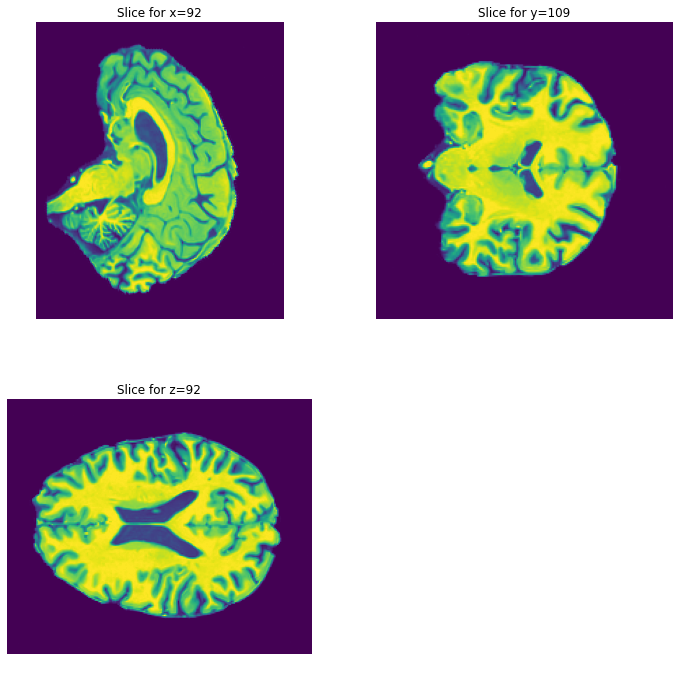

In [19]:
display_slices(imgs_3T[0])

## Training configuration

We will now set some training parameters:
  - number of epochs
  - optimizer $\rightarrow$ you can create a function that instantiates an optimizer for each training. You can use an [Adam optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) with a linear learning rate decay from 0.001 to 0.0001 ([this class](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PolynomialDecay) may be useful).
  - traing loss $\rightarrow$ MAE as in the reference paper. 

In [20]:
# to re-run before running the next cell
n_epochs = 20
loss ='mae'

## Execution

Execute the leave-one-out cross validation. After each of the 10 trainings, give some results:
  1. plot the evolution of the training loss
  2. show the test images (3T and 7T) and the inferred 7T image
  3. print the MAE before and after 3T-to-7T translation

At the end of the 10 trainings, print the MAE over the 10 subjects before and after 3T-to-7T translation.

Fold 0
0.16378801045416796 --> 0.17310155379790967
Fold 1
0.163788010454168 --> 0.17307774366727646
Fold 2
0.16378801045416774 --> 0.1633265302719367
Fold 3
0.16378801045416802 --> 0.165644805472982
Fold 4
0.16378801045416833 --> 0.16438034116706082
Fold 5


<ipython-input-21-336791ebdd5d>:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
<ipython-input-18-c0b35bf31ffa>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(2, 2, figsize=(12,12))


0.16378801045416813 --> 0.15945485039439763
Fold 6
0.16378801045416813 --> 0.16247989600134216
Fold 7
0.1637880104541685 --> 0.2360729298005721
Fold 8
0.1637880104541682 --> 0.1611946533348596
Fold 9
0.1637880104541681 --> 0.1755214682837187


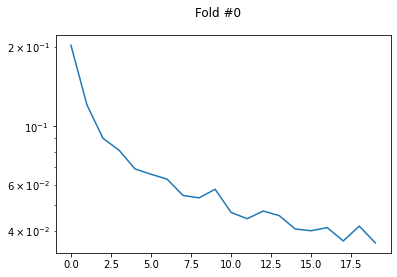

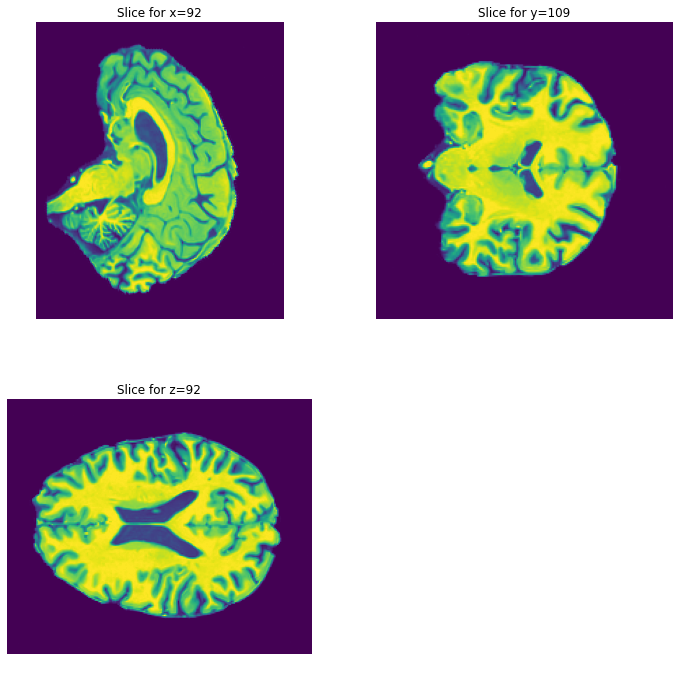

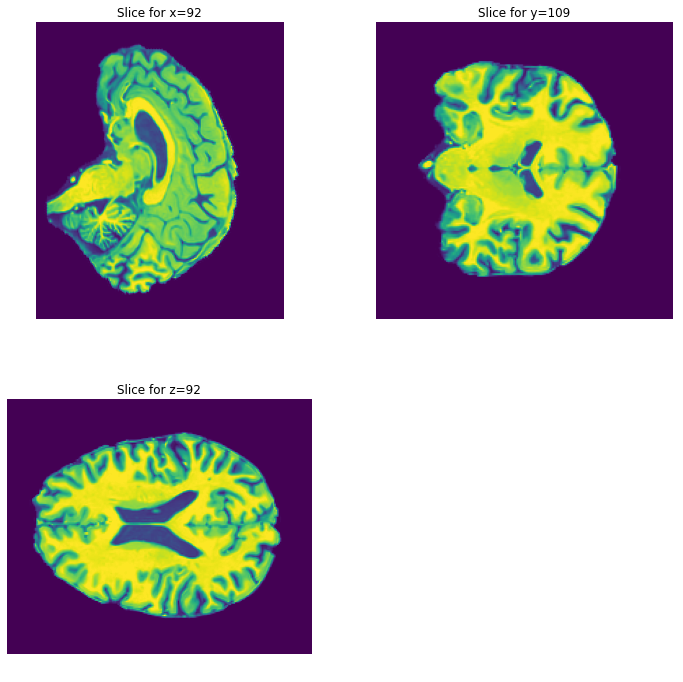

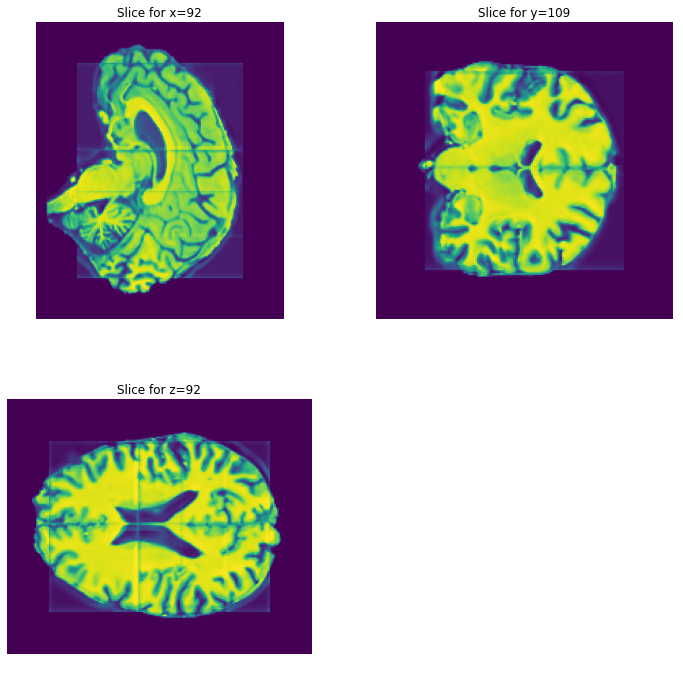

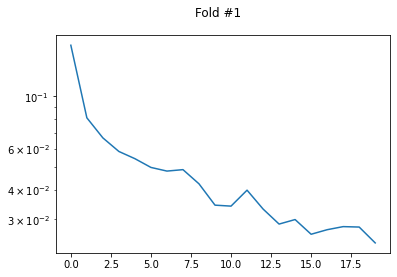

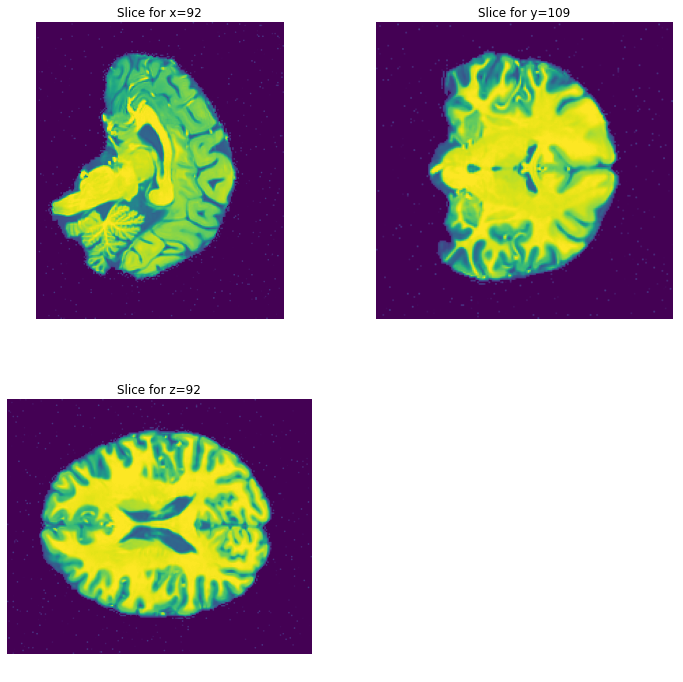

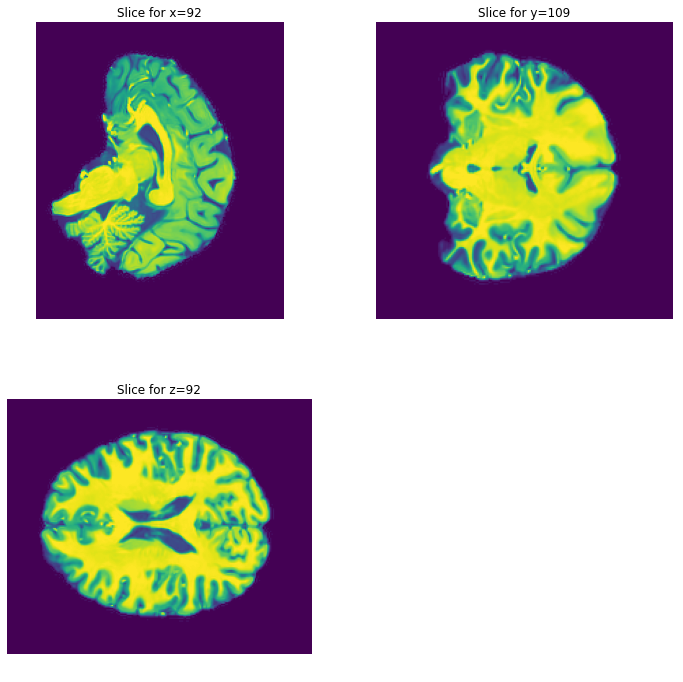

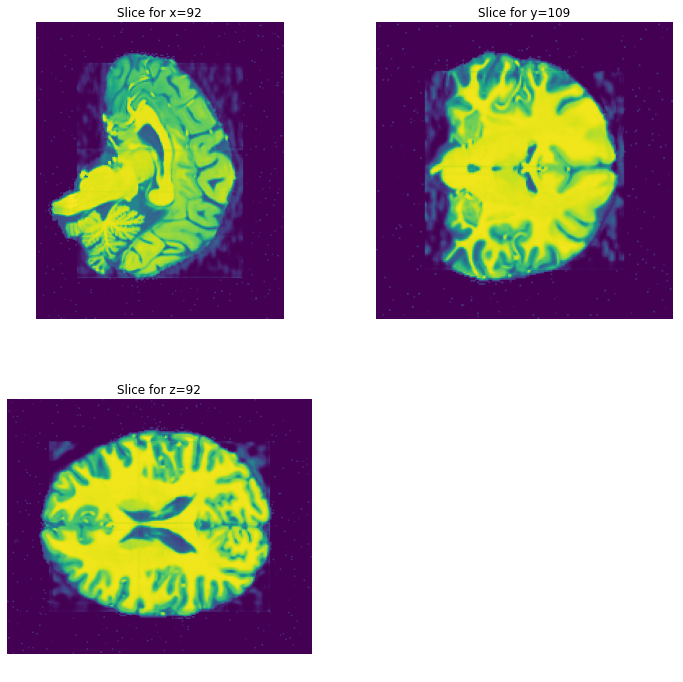

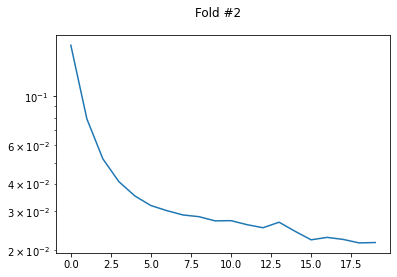

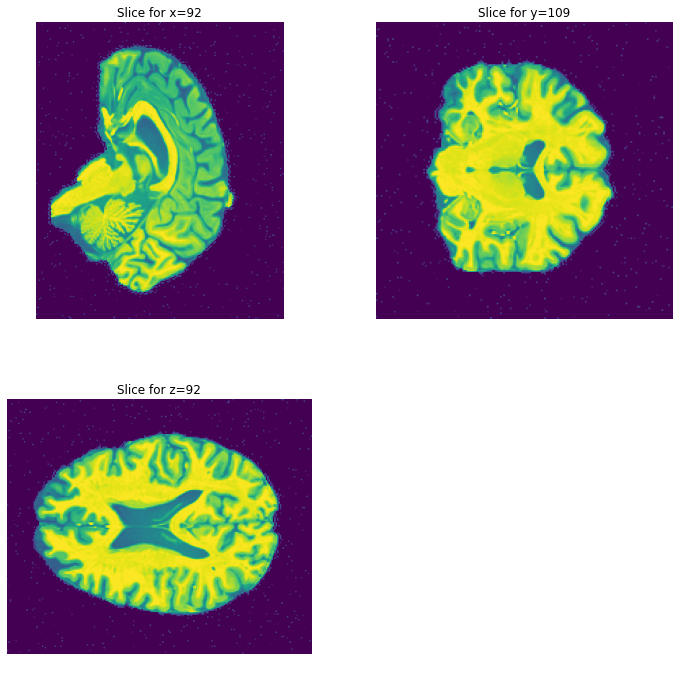

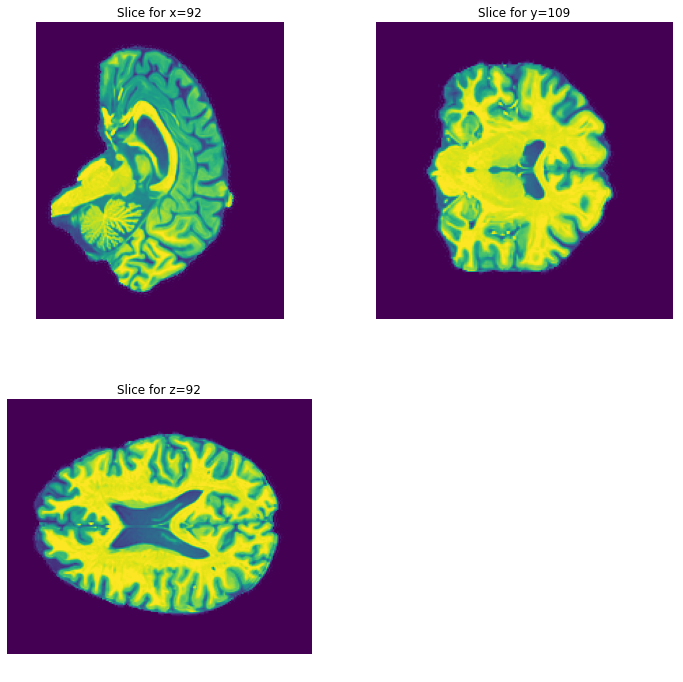

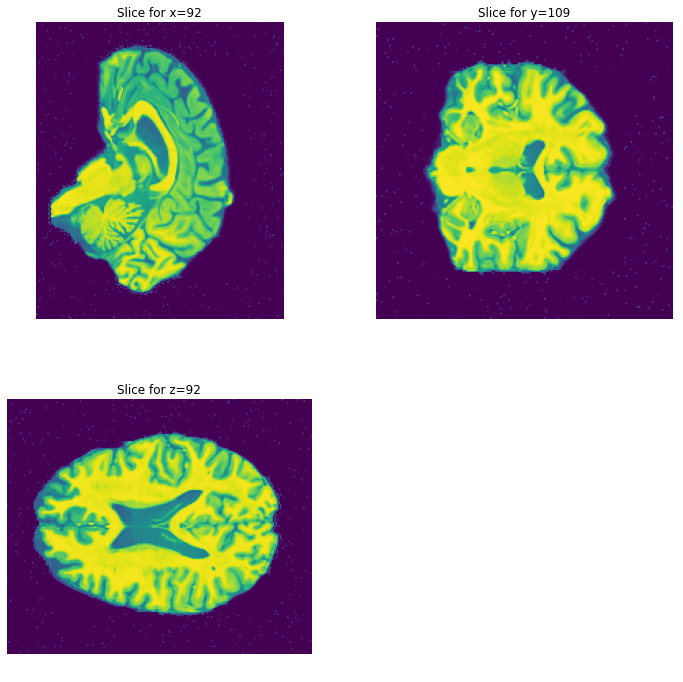

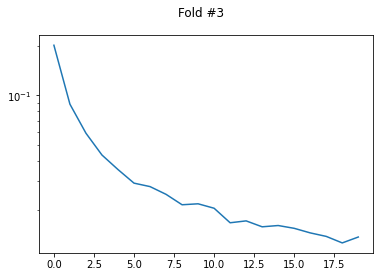

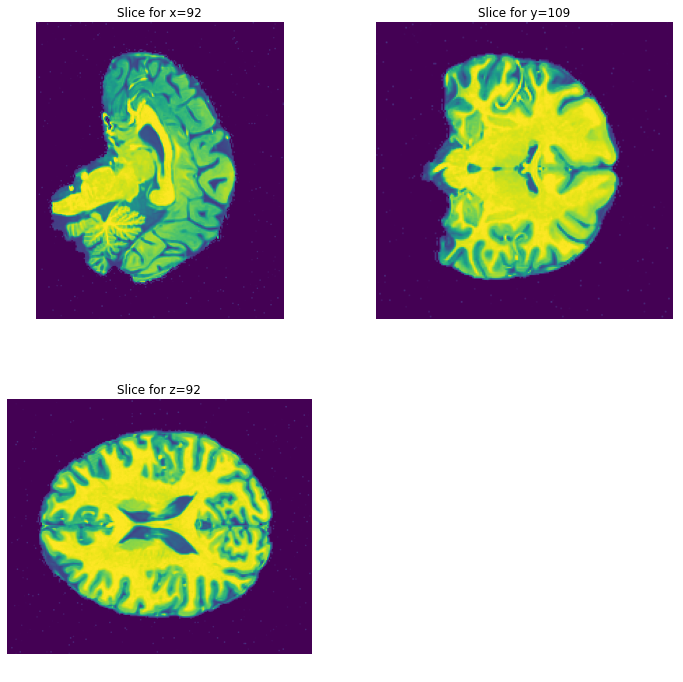

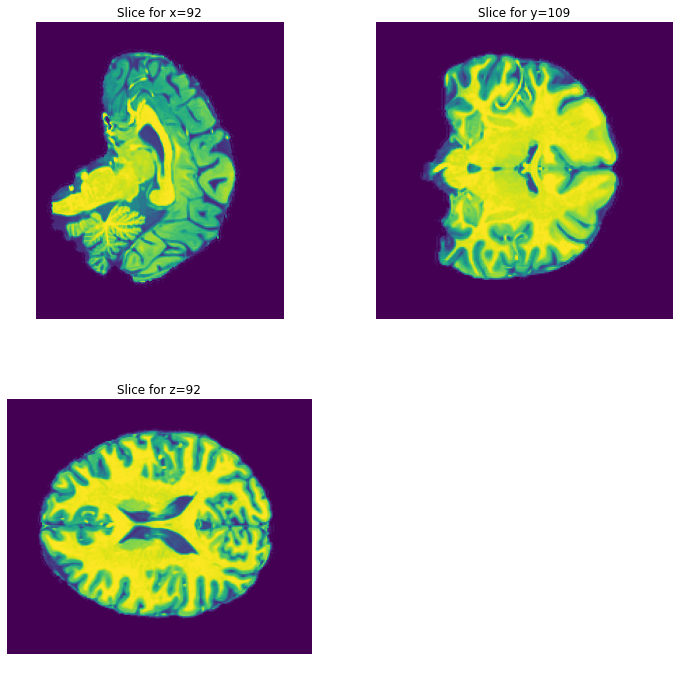

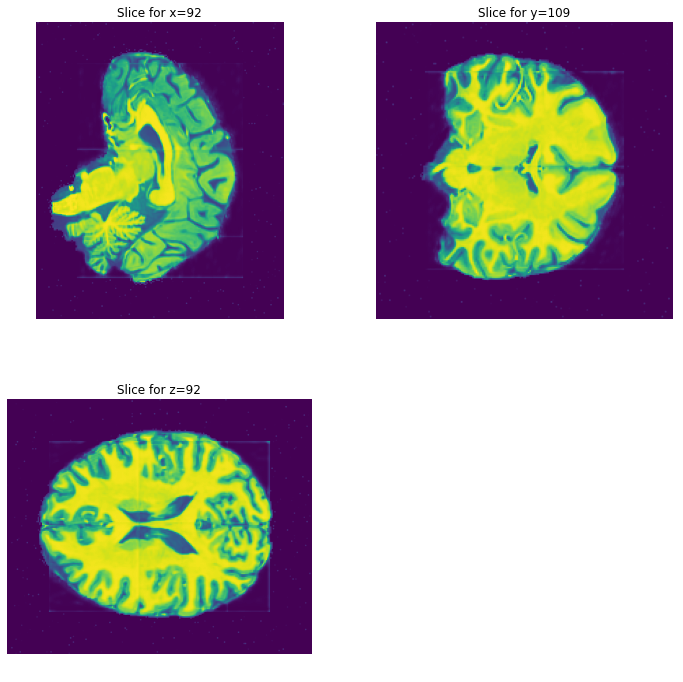

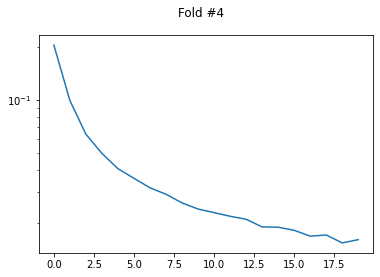

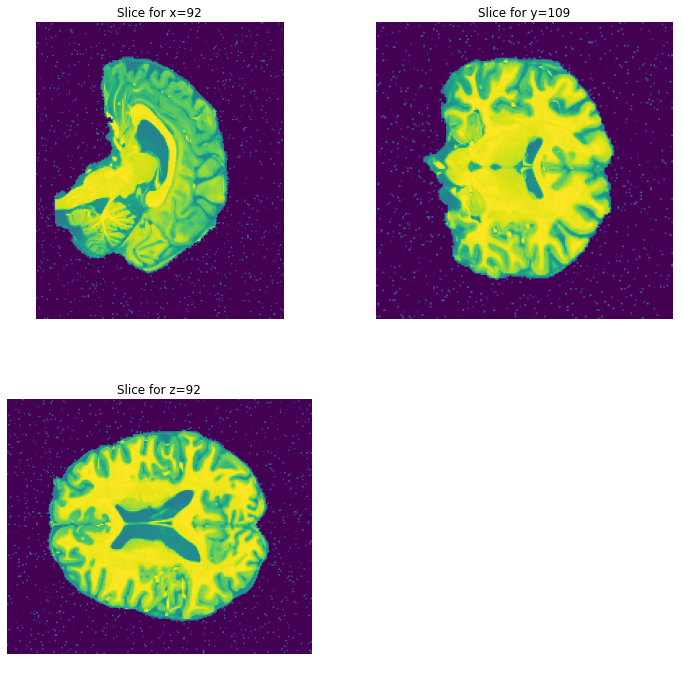

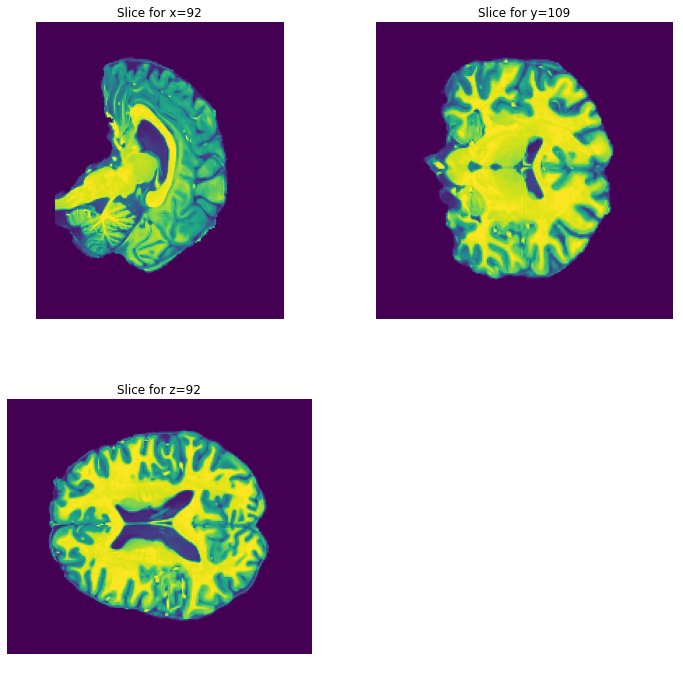

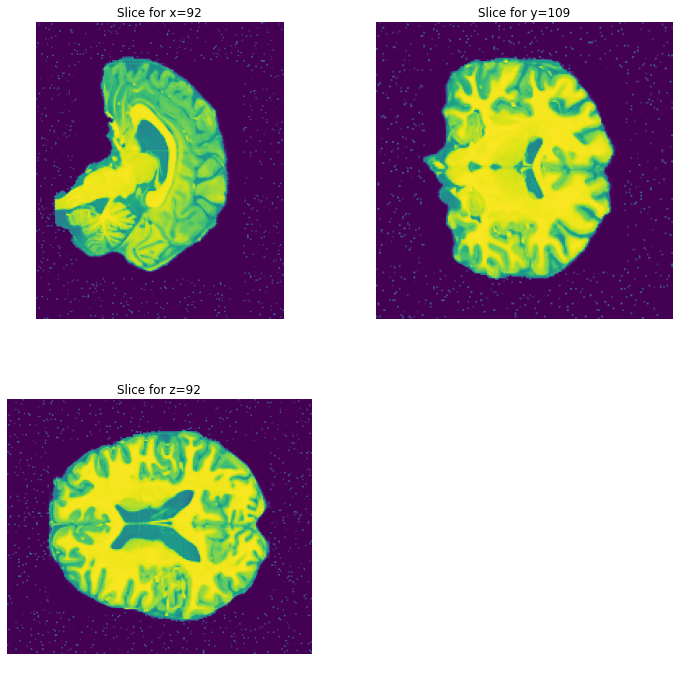

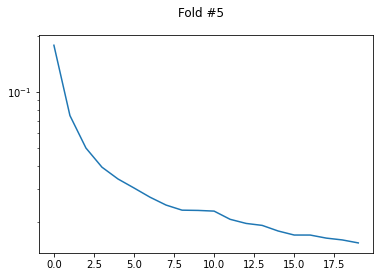

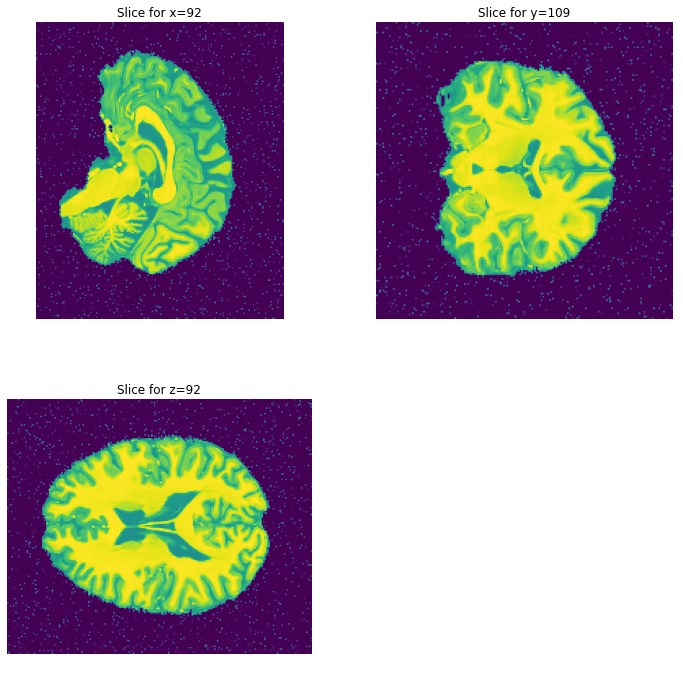

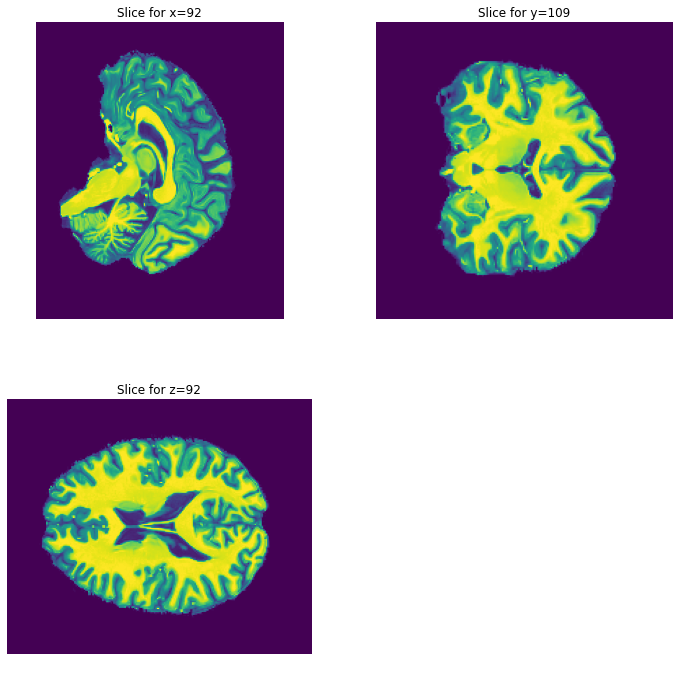

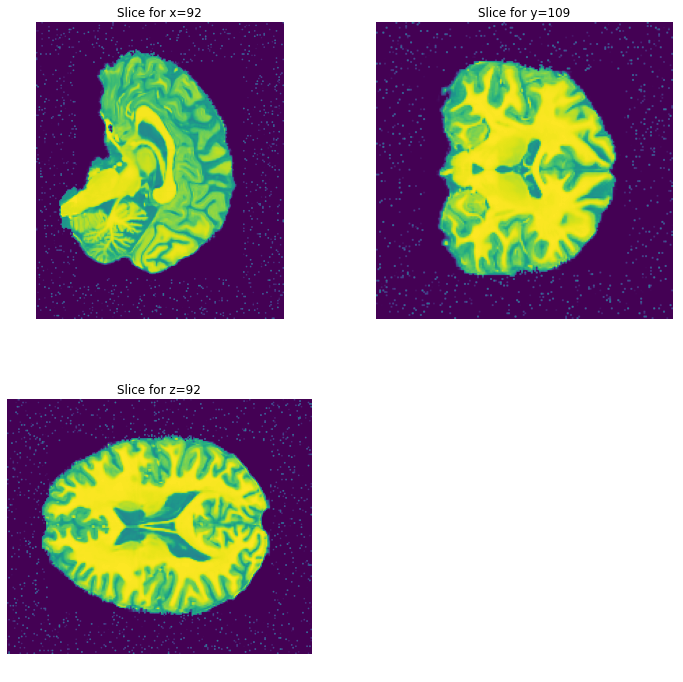

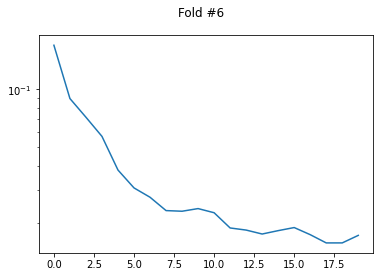

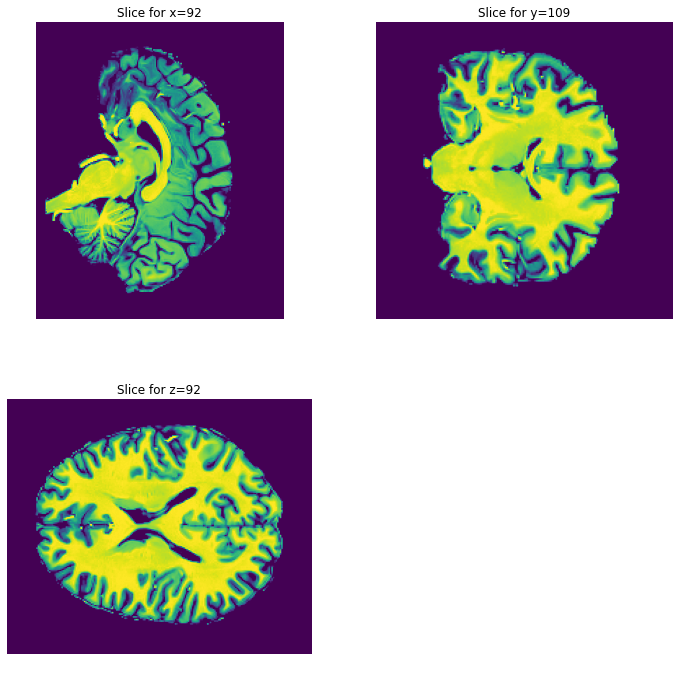

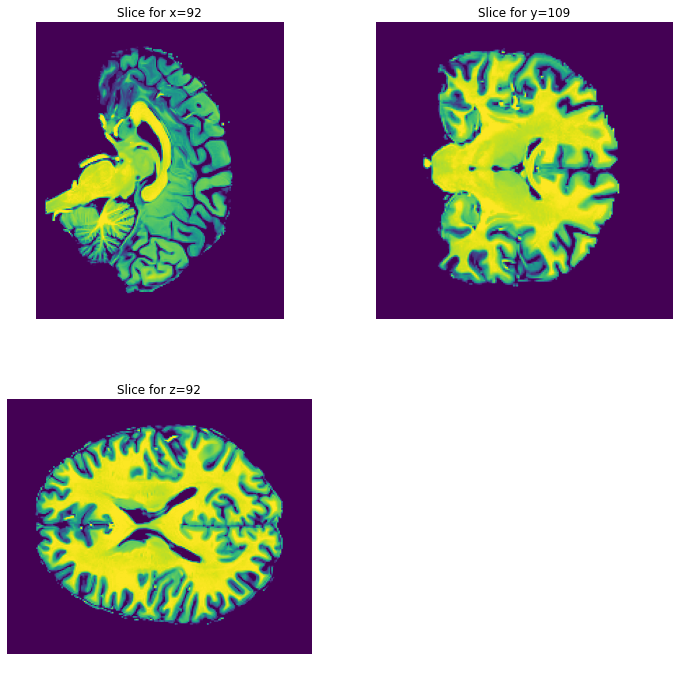

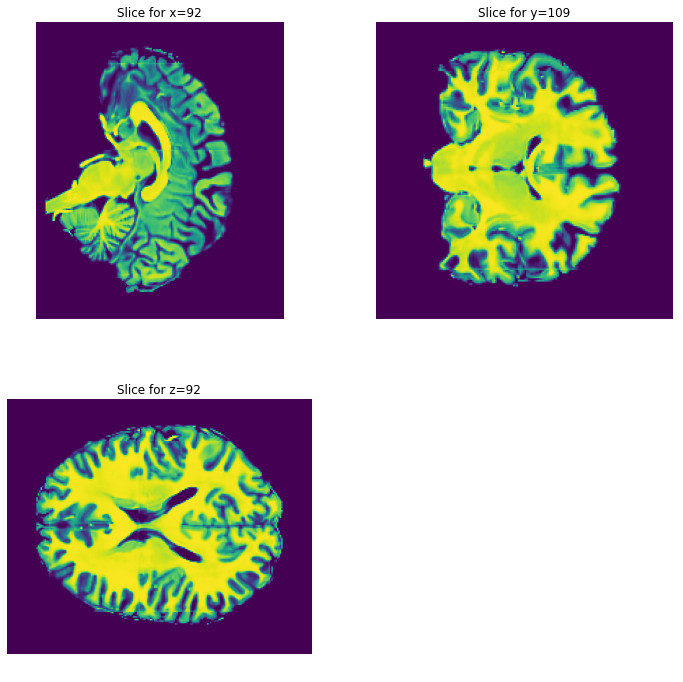

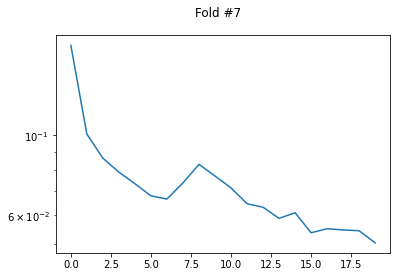

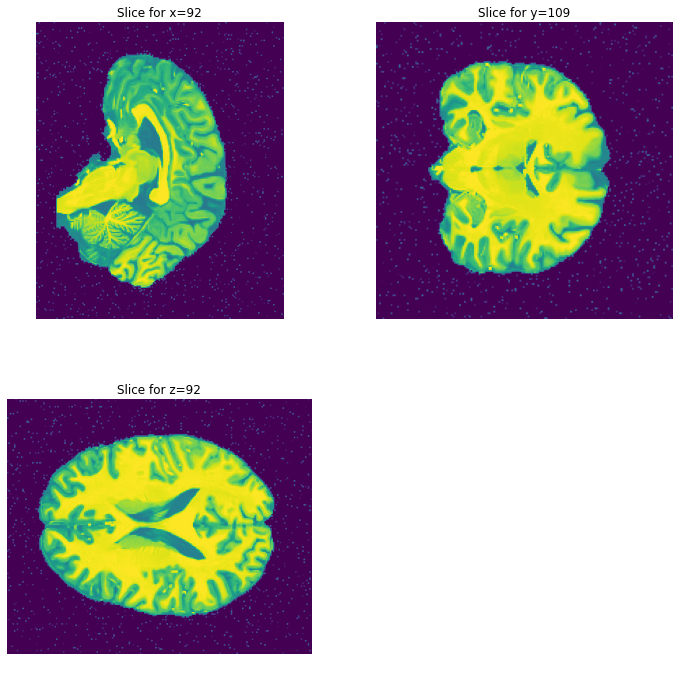

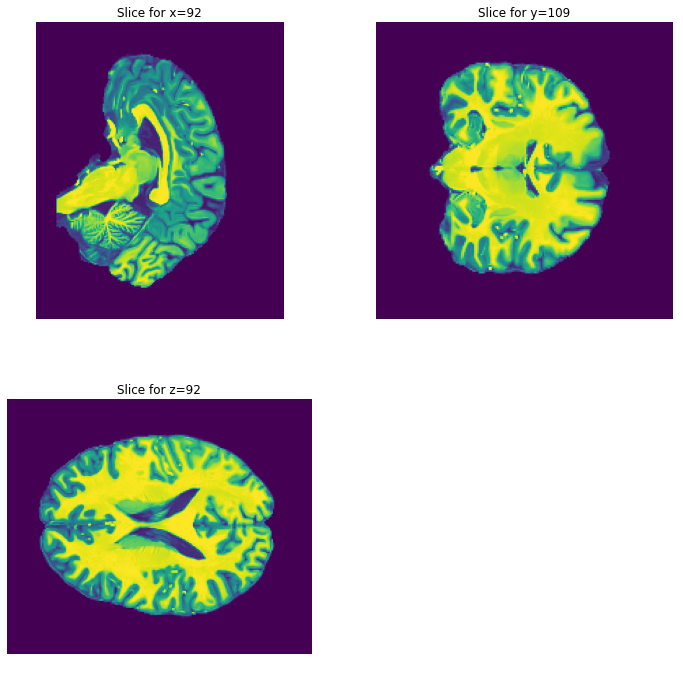

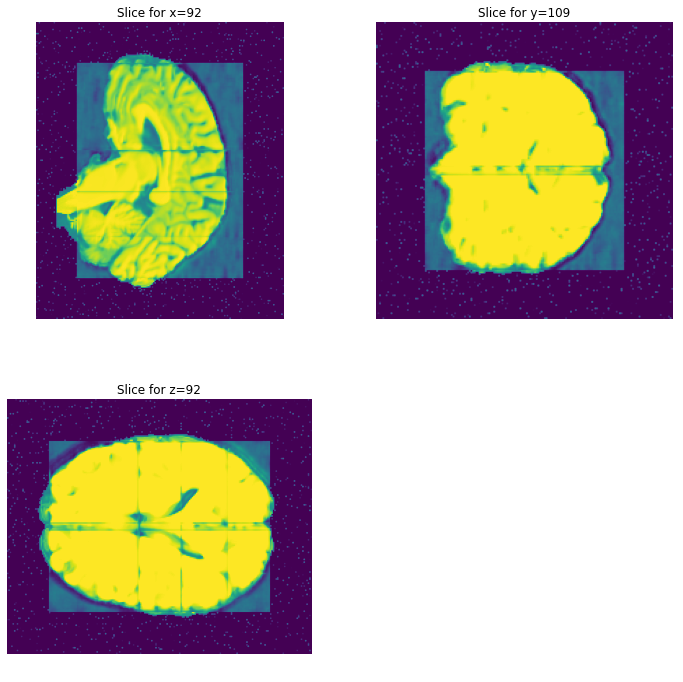

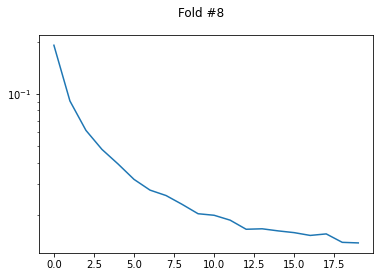

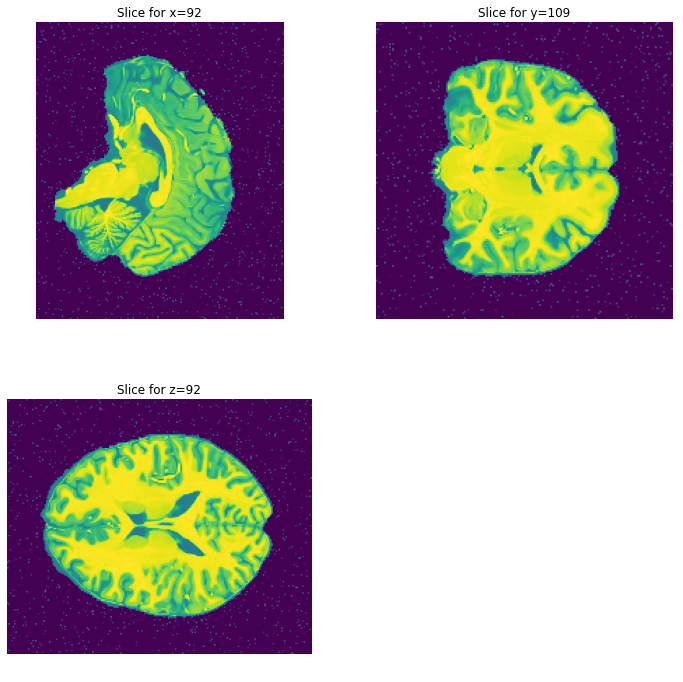

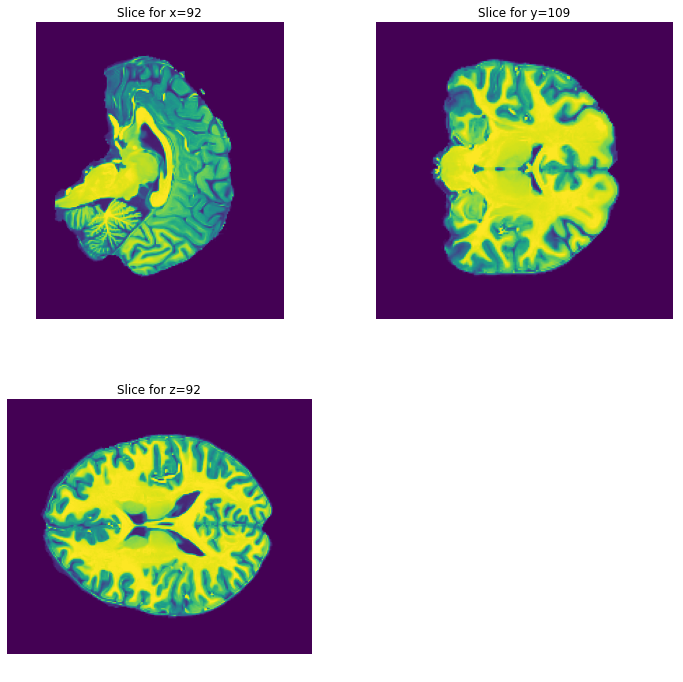

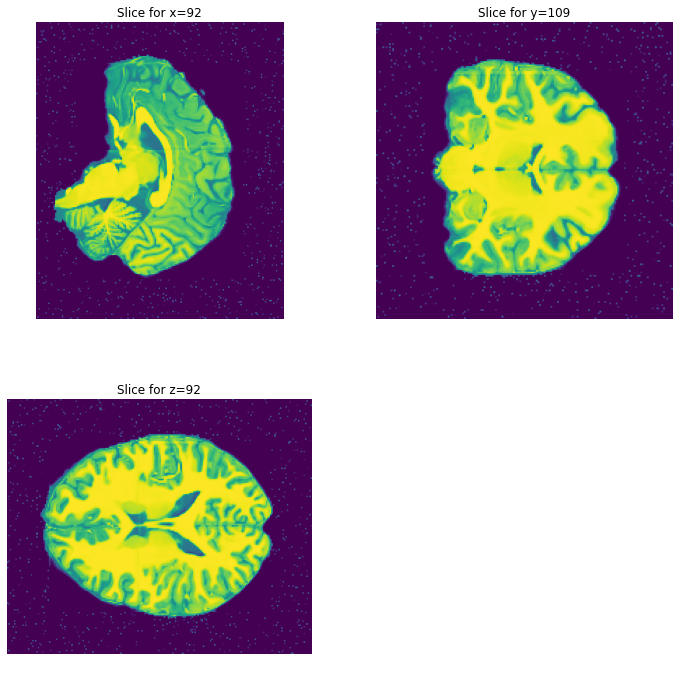

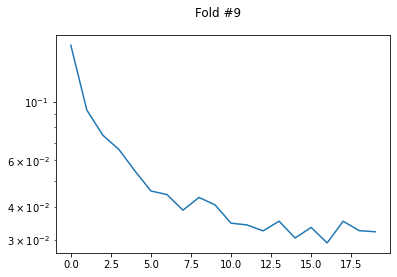

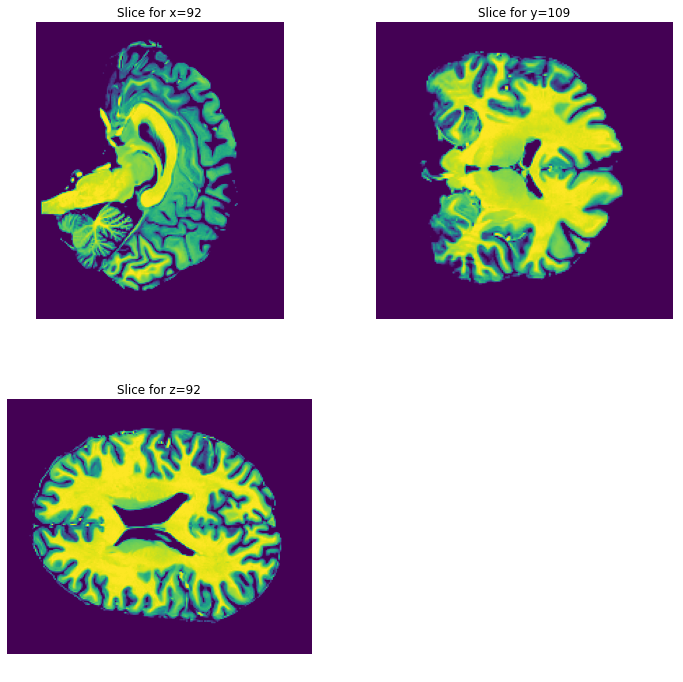

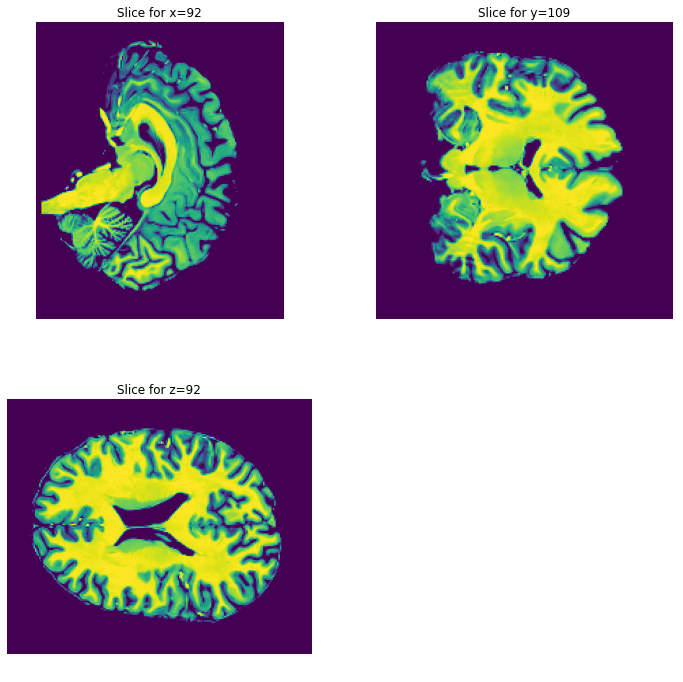

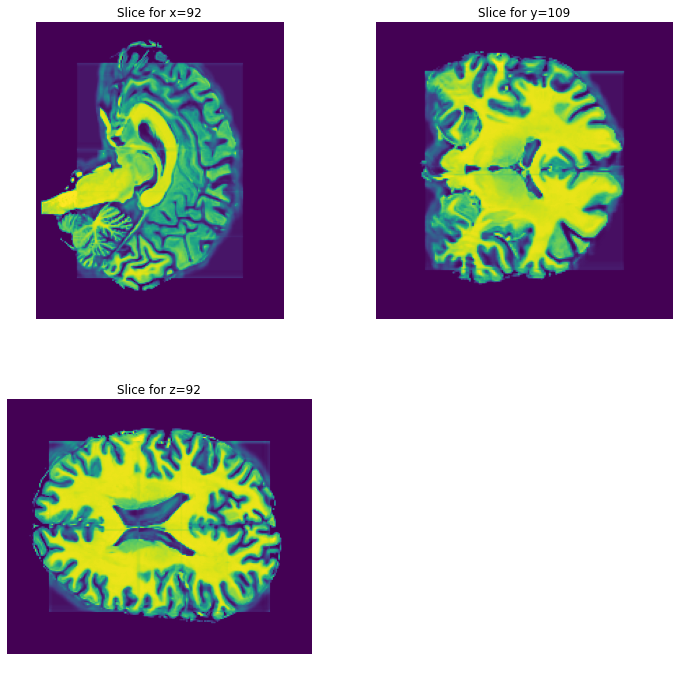

In [21]:
all_mae_history = []

for i in range(10):
  print(f'Fold {i}')
  train_ids = [j for j in range(10) if j!=i]
  train_dataset = instantiate_dataset(train_ids)
  lr_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=0.001,
    end_learning_rate=0.0001,
    decay_steps=10000,
    power=1.0)
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
  model = CNNModel()
  model.compile(optimizer=optimizer, loss=loss)
  
  history = model.fit(train_dataset, epochs=n_epochs, verbose=0)

  mae_history = history.history['loss']
  all_mae_history.append(mae_history)
  
  fig, ax = plt.subplots()
  ax.plot(range(len(mae_history)), mae_history)
  ax.set_yscale('log')
  fig.suptitle(f'Fold #{i}')
  fig.show()

  LQ_test, HQ_test, inferred_test = imgs_3T[i], imgs_7T[i], inference_function(imgs_3T[i], model)
  display_slices(LQ_test)
  display_slices(HQ_test)
  display_slices(inferred_test)

  print(np.abs(LQ_test).mean(), '-->', np.abs(inferred_test).mean())